In [163]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns;
from sklearn.model_selection import train_test_split

import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error as MSE

In [164]:
# Inladen data huisje

df = pd.read_csv('df0116_perdag', index_col=0)
df_new = pd.DataFrame(df.perdag_verbruik).dropna()
df_new.index = pd.to_datetime(df_new.index)

In [165]:
# Functie om verbruik vorige dag als feature meegeven, kan ook meerdere dagen meenemen als je n_in groter dan 1 maakt.

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = pd.concat(cols, axis=1)
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg.values

df_newer = series_to_supervised(df_new, n_in=1)

In [166]:
# Nieuwe feature toevoegen als kolom
df_new['1dag'] = 0
df_new['1dag'][1:] = df_newer[:, -2]


/tmp/ipykernel_15483/3155358369.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['1dag'][1:] = df_newer[:, -2]


In [167]:
# Tijdreeks stationair maken

def stationary(df):
    verschillen_perdag_verbruik = []
    for i in range(len(df) -1 ):
        verschil = df.iloc[i+1, 0] - df.iloc[i, 0]
        verschillen_perdag_verbruik.append(float(verschil))
    
    df['stationair'] = 0
    df['stationair'].iloc[1:] = verschillen_perdag_verbruik
    
    return df

df_stat = stationary(df_new)

/tmp/ipykernel_15483/1708669820.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['stationair'].iloc[1:] = verschillen_perdag_verbruik


In [168]:
# Data splitsen in train en test data

train = df_stat.loc[(df_stat.index < '2019-11-1')]
test = df_stat.loc[(df_stat.index >= '2019-11-1')]

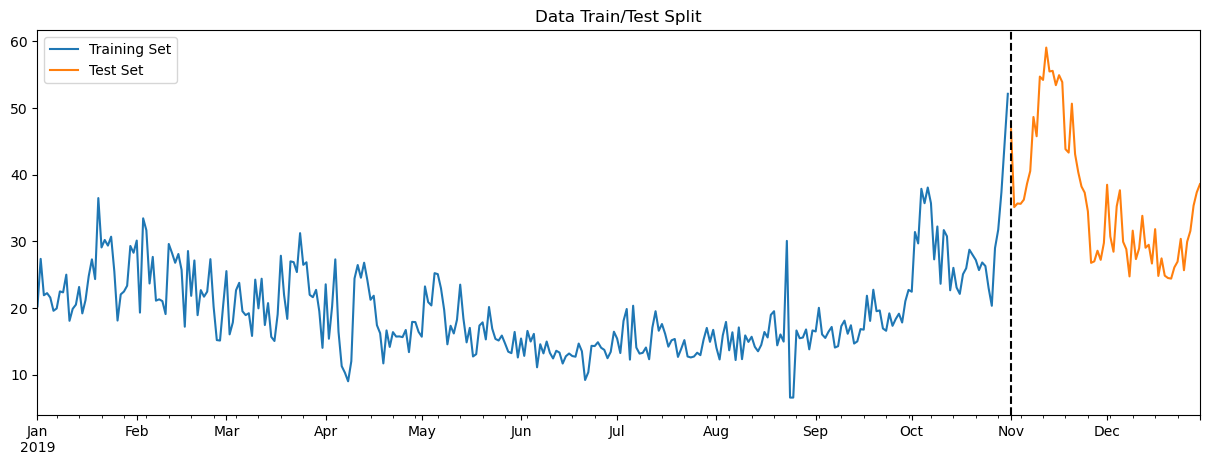

In [169]:
# Visaluatie van de gesplitste data per dag verbruik

fig, ax = plt.subplots(figsize=(15,5))
train['perdag_verbruik'].plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test['perdag_verbruik'].plot(ax=ax, label='TestSet')
ax.axvline('2019-11-01', color='black', ls= '--')
ax.legend(['Training Set', 'Test Set'])

plt.show()

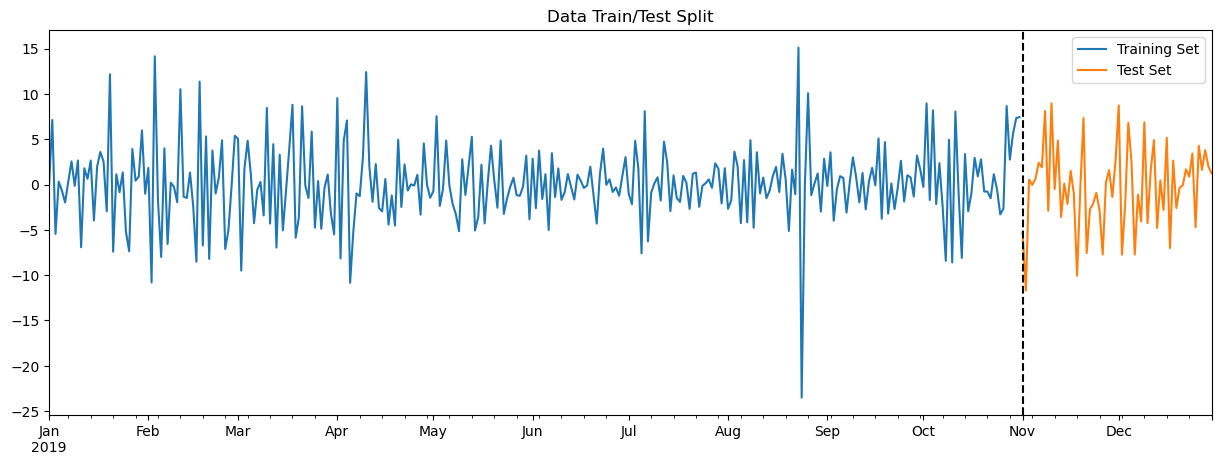

In [170]:
# Visaluatie van de gesplitste data stationair

fig, ax = plt.subplots(figsize=(15,5))
train['stationair'].plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test['stationair'].plot(ax=ax, label='TestSet')
ax.axvline('2019-11-01', color='black', ls= '--')
ax.legend(['Training Set', 'Test Set'])

plt.show()

In [171]:
# Funcite om de features dayofweek en month toe te voegen.

def create_features(df):
    
    df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month

    return df

df2 = create_features(df_stat)
df2

,perdag_verbruik,1dag,stationair,dayofweek,month
2019-01-01,20.2435,0.0000,0.0000,1,1
2019-01-02,27.3680,20.2435,7.1245,2,1
2019-01-03,21.9125,27.3680,-5.4555,3,1
2019-01-04,22.2255,21.9125,0.3130,4,1
2019-01-05,21.5635,22.2255,-0.6620,5,1
...,...,...,...,...,...
2019-12-26,29.9420,25.6660,4.2760,3,12
2019-12-27,31.5620,29.9420,1.6200,4,12
2019-12-28,35.3530,31.5620,3.7910,5,12
2019-12-29,37.3550,35.3530,2.0020,6,12


In [172]:
# Train en Test tabellen met de juiste variabele maken.

train = create_features(train).dropna()
train = train.drop(columns = 'perdag_verbruik')
test = create_features(test).dropna()
test = test.drop(columns = 'perdag_verbruik')
# test = test[train.columns]

TARGET = 'stationair'

X_train = train.drop(columns= TARGET)
y_train= train[TARGET]

X_test = test.drop(columns = TARGET)
y_test = test[TARGET]

/tmp/ipykernel_15483/4273062604.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dayofweek'] = df.index.dayofweek
/tmp/ipykernel_15483/4273062604.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['month'] = df.index.month
/tmp/ipykernel_15483/4273062604.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

In [173]:
# Model zonder hyperparameters

reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)])
yhat = reg.predict(X_test)

[0]	validation_0-rmse:3.81926	validation_1-rmse:4.60739
[1]	validation_0-rmse:3.36632	validation_1-rmse:4.74681
[2]	validation_0-rmse:3.07020	validation_1-rmse:4.89440
[3]	validation_0-rmse:2.79052	validation_1-rmse:5.04859
[4]	validation_0-rmse:2.60096	validation_1-rmse:5.14821
[5]	validation_0-rmse:2.37631	validation_1-rmse:5.12269
[6]	validation_0-rmse:2.25554	validation_1-rmse:5.19130
[7]	validation_0-rmse:2.16573	validation_1-rmse:5.25701
[8]	validation_0-rmse:2.05591	validation_1-rmse:5.30467
[9]	validation_0-rmse:1.98138	validation_1-rmse:5.30655
[10]	validation_0-rmse:1.88257	validation_1-rmse:5.29801
[11]	validation_0-rmse:1.77198	validation_1-rmse:5.29523
[12]	validation_0-rmse:1.70286	validation_1-rmse:5.37229
[13]	validation_0-rmse:1.61940	validation_1-rmse:5.41643
[14]	validation_0-rmse:1.55602	validation_1-rmse:5.41605
[15]	validation_0-rmse:1.52866	validation_1-rmse:5.40631
[16]	validation_0-rmse:1.45245	validation_1-rmse:5.40963
[17]	validation_0-rmse:1.37922	validation

In [174]:
#Model met optimale hyperparameters na GridSearchCV

params = {
    'n_estimators': [10,100,1000],
    'min_child_weight': [4, 5],
    'gamma': [i / 10.0 for i in range(3, 6)],
    'subsample': [i / 10.0 for i in range(6, 11)],
    'colsample_bytree': [i / 10.0 for i in range(6, 11)],
    'max_depth': [2, 3, 4]
}

xgb_reg = xgb.XGBRegressor()
grid = GridSearchCV(xgb_reg, params)
grid.fit(X_train, y_train)
gridcv_xgb = grid.best_estimator_
yhat = gridcv_xgb.predict(X_test)
print("r2-score: % f" % (r2_score(y_test, gridcv_xgb.predict(X_test))))
print("RMSE : % f" %(np.sqrt(MSE(y_test, yhat))))

r2-score:  0.040244
RMSE :  4.447484


In [175]:
# optimale parameters

grid.best_params_

{'colsample_bytree': 0.7,
 'gamma': 0.3,
 'max_depth': 3,
 'min_child_weight': 5,
 'n_estimators': 10,
 'subsample': 0.6}

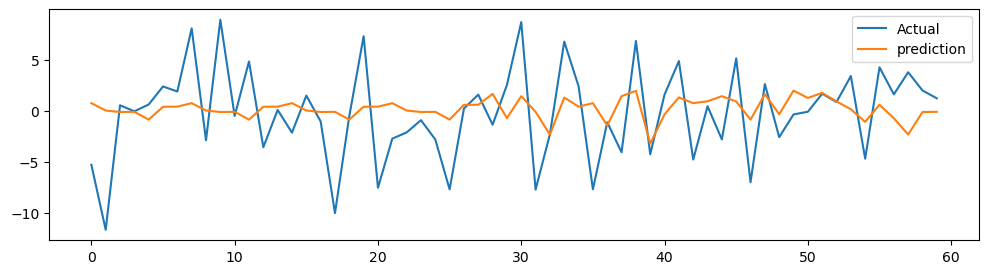

In [176]:
# Visualisatie voorspelling stationaire data

plt.plot(y_test.values, label='Actual')
plt.plot(yhat, label='prediction')
plt.legend()
plt.show()

In [177]:
# Maken laatste tabel om stationaire data terug te zetten naar per dag verbruik

real = df_stat.loc[(df_stat.index >= '2019-10-31')]
real = real['perdag_verbruik'][:-1]
real = pd.DataFrame(real)
prediction= list(yhat)
real['pred_stat'] = prediction
new = np.array(real['perdag_verbruik'])+np.array(real['pred_stat'])
emptys = [np.nan]
newer = list(new)
emptys.extend(newer)
real['real_prediction'] = emptys[:-1]

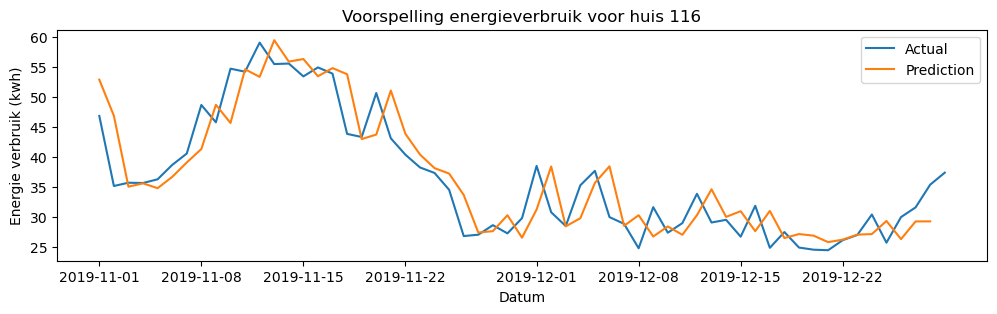

In [178]:
# Visualisatie voorspelling van per dag verbruik

plt.plot(real.perdag_verbruik[1:], label='Actual')
plt.plot(real.real_prediction[:-1], label='Prediction')
plt.xlabel('Datum')
plt.ylabel('Energie verbruik (kwh)')
plt.title('Voorspelling energieverbruik voor huis 116')
plt.legend()
plt.rcParams["figure.figsize"] = (12,3)
plt.show()

In [179]:
# De uiteindelijke r2 score

print("r2-score: % f" % (r2_score(real['perdag_verbruik'][1:], real['real_prediction'][1:])))
print("RMSE : % f" %(np.sqrt(MSE(real['perdag_verbruik'][1:], real['real_prediction'][1:]))))



r2-score:  0.792970
RMSE :  4.481680
